# 1. Basic Analysis of the Data
## 1.1 Data Description

In [17]:
import pandas as pd
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_25sec.csv')
print(df.describe())

# blacklist = ["22K", "25I", "29N", "39Y", "32S", "37T"]
# df_filtered = df[~df['Participant'].isin(blacklist)]
# print(df_filtered.describe())


        Attention      NumFix   AvgFixDur    NumBlink   AvgBlinkDur  \
count  960.000000  960.000000  960.000000  960.000000    960.000000   
mean     0.572917   49.222917  291.160120   12.300000    476.425339   
std      0.494912   16.784231   94.180617    7.810023   1636.103780   
min      0.000000    0.000000    0.000000    0.000000      0.000000   
25%      0.000000   43.000000  238.020494    6.000000    142.857143   
50%      1.000000   53.000000  282.941441   11.000000    200.000000   
75%      1.000000   61.000000  337.992424   17.000000    296.078431   
max      1.000000   79.000000  976.388889   47.000000  25000.000000   

        AvgPupDia   VarPupDia  OffStimFram   AvgSacAmp  AvgFixDisp  \
count  957.000000  957.000000   960.000000  960.000000  960.000000   
mean     3.612554    0.181057    20.933333    6.007252    0.198619   
std      0.613853    0.152582    34.746929    1.785674    0.052327   
min      1.357506    0.000000     0.000000    0.000000    0.000000   
25%      3

## 1.2 Proportion of Attention Distribution Among Participants

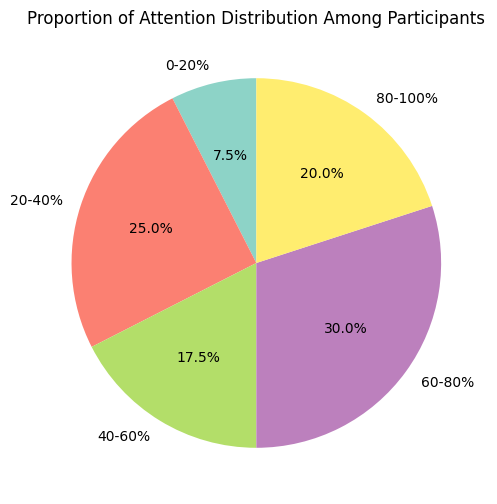

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_25sec.csv')

# Calculate the proportion of attention == 1 for each participant
attention_proportion = df.groupby('Participant')['Attention'].mean()

# Define bins for the categories
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"]

# Categorize the proportions into the bins
categories = pd.cut(attention_proportion, bins, labels=labels, include_lowest=True, ordered=True)

# Count the number of participants in each bin
category_counts = categories.value_counts(sort=False)
category_counts_normalized = category_counts / category_counts.sum()

# Plotting
plt.figure(figsize=(10, 6))
category_counts_normalized.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap="Set3", labels=labels)
plt.ylabel('')  # Remove the y-label as it is unnecessary for pie charts
plt.title('Proportion of Attention Distribution Among Participants')
plt.show()


# 2. Identify the best window size using the random forest model

- Cross-validation: Instead of a single train-test split for each iteration, consider using cross-validation. This will provide a more robust measure of model performance as it evaluates the model on multiple train-test splits. You can use cross_val_score for this, but note that it requires splitting the data such that each participant's data is entirely in either the training or the testing set, which might require custom splitting strategies.

- Feature Importance and Selection: Depending on the results and the importance of different features, you might consider feature selection or engineering to improve model performance. RandomForest provides feature importance scores that can help you understand which features are most influential in making predictions.

- Parameter Tuning: You're using the default parameters of RandomForestClassifier. Consider tuning the hyperparameters, like n_estimators, max_depth, etc., using techniques such as grid search or random search to potentially improve model accuracy.

- Validation Strategy: The approach to split data by participants is excellent for ensuring that the model generalizes well over different individuals. However, make sure that your way of splitting truly reflects the independent data distributions you expect to encounter in practice.

- Error Analysis: After determining the best window size, it might be useful to perform an error analysis to see where the model performs poorly. This could provide insights into further improvements in feature engineering or model choice.

- Model Complexity: Evaluate if RandomForest is the best choice or if other models (e.g., SVM, logistic regression, or even neural networks) might yield better results for your specific type of data and problem.

**Cross Validation Implementation:**

In [8]:
import pandas as pd
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Load CSV files into DataFrames
window_sizes = [5 * i for i in range(1, 9)]
dataframes = [pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{w}sec.csv") for w in window_sizes]

# Function to prepare data by participant
def prepare_data(df):
    X = df[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
    y = df['Attention']
    groups = df['Participant']
    return X, y, groups

# Number of iterations and random states
iterations = 10
random_states = range(iterations)

# Loop through each DataFrame and random states
results = {w: [] for w in window_sizes}
for w, df in zip(window_sizes, dataframes):
    X, y, groups = prepare_data(df)
    # Define the cross-validation strategy
    gkf = GroupKFold(n_splits=5)
    
    # Collect cross-validation scores for each random state
    model_scores = []
    for random_state in random_states:
        clf = RandomForestClassifier(random_state=random_state)
        scores = cross_val_score(clf, X, y, groups=groups, cv=gkf)
        model_scores.extend(scores)

    # Store average accuracy for this window across all random states
    results[w].append(np.mean(model_scores))

# Calculate average accuracy for each window size
average_results = {w: np.mean(acc) for w, acc in results.items()}

# Print results
for w, avg_acc in average_results.items():
    print(f"Window size: {w} sec, Average accuracy: {avg_acc:.3f}")

# Find the best window size
best_window = max(average_results, key=average_results.get)
print(f"Best window size: {best_window} sec with average accuracy: {average_results[best_window]:.3f}")


Window size: 5 sec, Average accuracy: 0.529
Window size: 10 sec, Average accuracy: 0.542
Window size: 15 sec, Average accuracy: 0.581
Window size: 20 sec, Average accuracy: 0.585
Window size: 25 sec, Average accuracy: 0.606
Window size: 30 sec, Average accuracy: 0.612
Window size: 35 sec, Average accuracy: 0.619
Window size: 40 sec, Average accuracy: 0.613
Best window size: 35 sec with average accuracy: 0.619


**Add a blacklist to filter out the participants with missing data.**

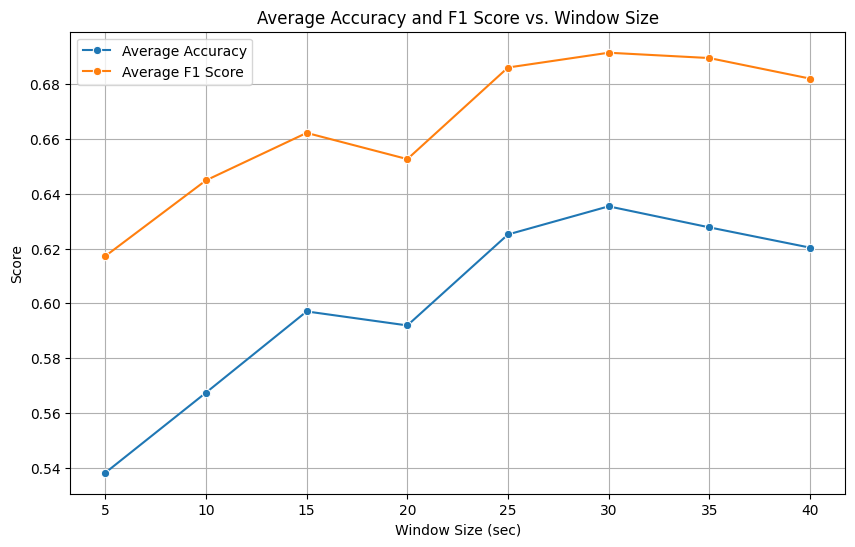

Window size: 5 sec, Average accuracy: 0.538, Average F1 score: 0.617
Window size: 10 sec, Average accuracy: 0.567, Average F1 score: 0.645
Window size: 15 sec, Average accuracy: 0.597, Average F1 score: 0.662
Window size: 20 sec, Average accuracy: 0.592, Average F1 score: 0.653
Window size: 25 sec, Average accuracy: 0.625, Average F1 score: 0.686
Window size: 30 sec, Average accuracy: 0.635, Average F1 score: 0.692
Window size: 35 sec, Average accuracy: 0.628, Average F1 score: 0.690
Window size: 40 sec, Average accuracy: 0.620, Average F1 score: 0.682
Best window size (accuracy): 30 sec with average accuracy: 0.635
Best window size (F1 score): 30 sec with average F1 score: 0.692


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# Load CSV files into DataFrames
window_sizes = [5 * i for i in range(1, 9)]
dataframes = [pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{w}sec.csv") for w in window_sizes]

# Blacklist of participants with missing data
blacklist = ["22K", "25I", "29N", "39Y", "32S", "37T"]

# Function to prepare data by participant, excluding blacklist
def prepare_data(df):
    df_filtered = df[~df['Participant'].isin(blacklist)]
    X = df_filtered[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
    y = df_filtered['Attention']
    groups = df_filtered['Participant']
    return X, y, groups

# Number of iterations and random states
iterations = 10
random_states = range(iterations)

# Loop through each DataFrame and random states
results = {w: {'accuracy': [], 'f1_score': []} for w in window_sizes}
for w, df in zip(window_sizes, dataframes):
    X, y, groups = prepare_data(df)
    # Define the cross-validation strategy
    gkf = GroupKFold(n_splits=5)
    
    # Collect cross-validation scores for each random state
    for random_state in random_states:
        clf = RandomForestClassifier(random_state=random_state)
        accuracy_scores = cross_val_score(clf, X, y, groups=groups, cv=gkf)
        f1_scorer = make_scorer(f1_score)
        f1_scores = cross_val_score(clf, X, y, groups=groups, cv=gkf, scoring=f1_scorer)
        results[w]['accuracy'].extend(accuracy_scores)
        results[w]['f1_score'].extend(f1_scores)

# Calculate average accuracy and F1 score for each window size
average_results = {w: {'average_accuracy': np.mean(scores['accuracy']), 'average_f1_score': np.mean(scores['f1_score'])} for w, scores in results.items()}

# Convert average_results to a DataFrame for plotting
average_results_df = pd.DataFrame.from_dict(average_results, orient='index').reset_index()
average_results_df.columns = ['window_size', 'average_accuracy', 'average_f1_score']

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='window_size', y='average_accuracy', data=average_results_df, marker='o', label='Average Accuracy')
sns.lineplot(x='window_size', y='average_f1_score', data=average_results_df, marker='o', label='Average F1 Score')
plt.xlabel('Window Size (sec)')
plt.ylabel('Score')
plt.title('Average Accuracy and F1 Score vs. Window Size')
plt.legend()
plt.grid(True)
plt.show()

# Print results
for w, metrics in average_results.items():
    print(f"Window size: {w} sec, Average accuracy: {metrics['average_accuracy']:.3f}, Average F1 score: {metrics['average_f1_score']:.3f}")

# Find the best window size based on accuracy
best_window_accuracy = max(average_results, key=lambda w: average_results[w]['average_accuracy'])
print(f"Best window size (accuracy): {best_window_accuracy} sec with average accuracy: {average_results[best_window_accuracy]['average_accuracy']:.3f}")

# Find the best window size based on F1 score
best_window_f1 = max(average_results, key=lambda w: average_results[w]['average_f1_score'])
print(f"Best window size (F1 score): {best_window_f1} sec with average F1 score: {average_results[best_window_f1]['average_f1_score']:.3f}")

**Plot the confusion matrix, ROC curve, and AUC**

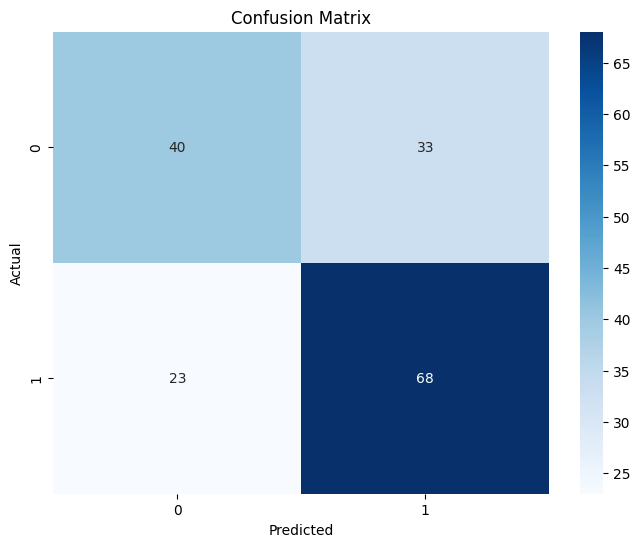

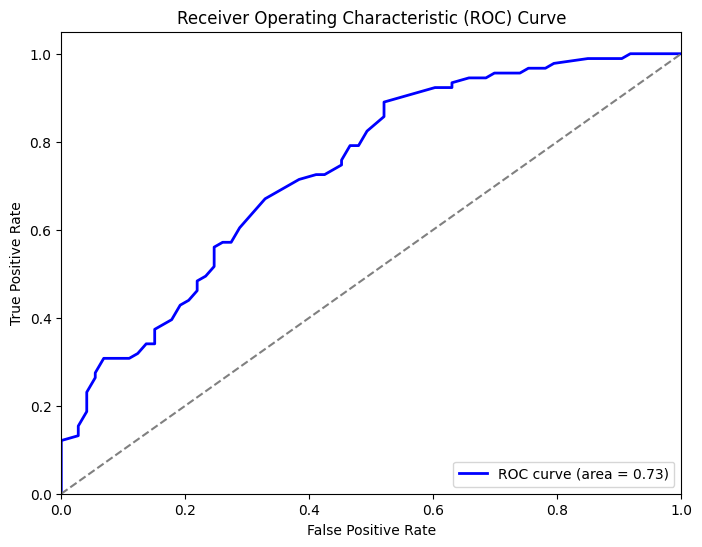

F1 score: 0.708


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data for the best window size (30 sec)
window_size = 30
df = pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{window_size}sec.csv")

# Blacklist of participants with missing data
blacklist = ["22K", "25I", "29N", "39Y", "32S", "37T"]

# Prepare the data
df_filtered = df[~df['Participant'].isin(blacklist)]
X = df_filtered[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
y = df_filtered['Attention']
groups = df_filtered['Participant']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=groups, random_state=42)

# Train the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the F1 score
print(f"F1 score: {f1_score(y_test, y_pred):.3f}")

**Try different machine learning models and plot their performance for different window sizes.**

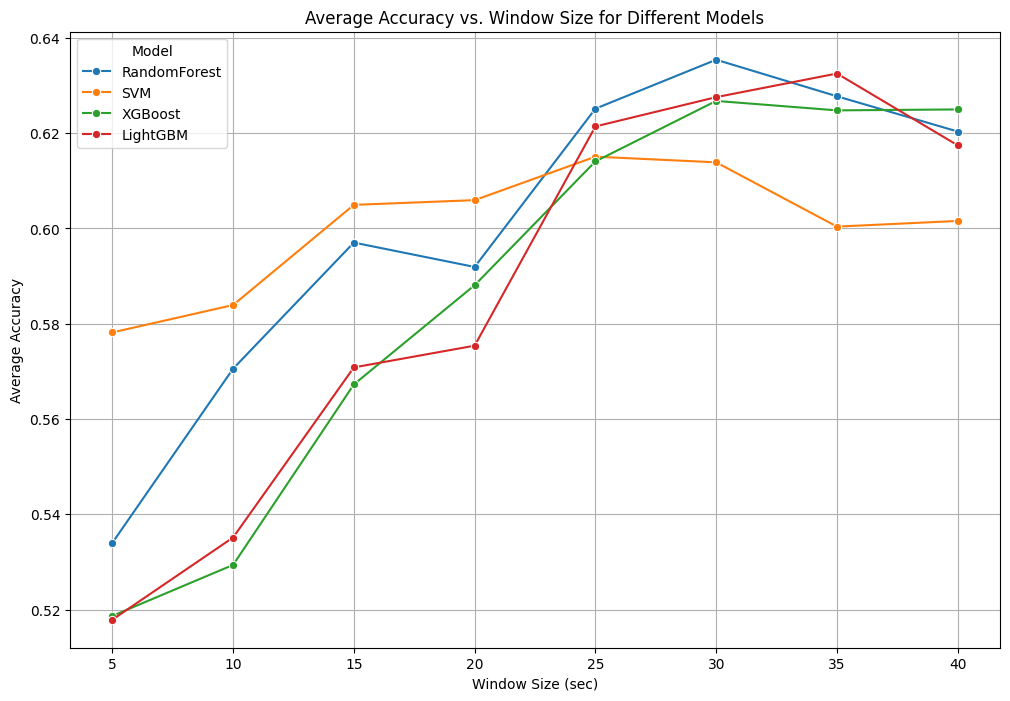

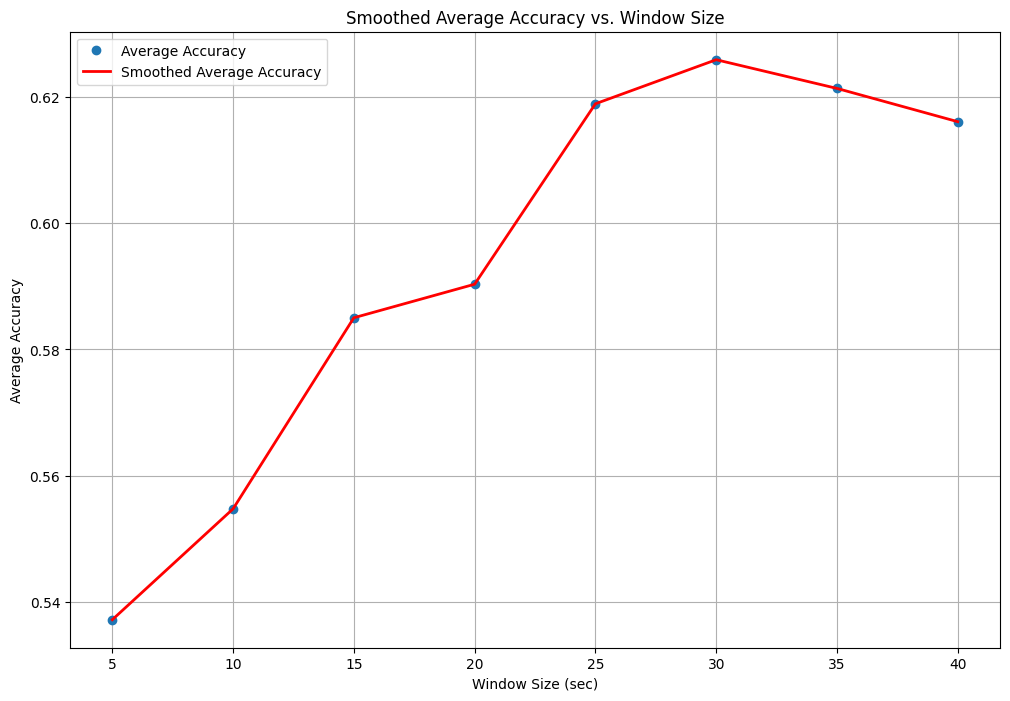

Overall Average Accuracies:
  Window size: 5 sec, Average accuracy: 0.537
  Window size: 10 sec, Average accuracy: 0.555
  Window size: 15 sec, Average accuracy: 0.585
  Window size: 20 sec, Average accuracy: 0.590
  Window size: 25 sec, Average accuracy: 0.619
  Window size: 30 sec, Average accuracy: 0.626
  Window size: 35 sec, Average accuracy: 0.621
  Window size: 40 sec, Average accuracy: 0.616
Best window size based on overall smoothed average accuracy: 30.0 sec


In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from statsmodels.nonparametric.smoothers_lowess import lowess

# Load CSV files into DataFrames
window_sizes = [5 * i for i in range(1, 9)]
dataframes = [pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{w}sec.csv") for w in window_sizes]

# Blacklist of participants with missing data
blacklist = ["22K", "25I", "29N", "39Y", "32S", "37T"]

# Function to prepare data by participant, excluding blacklist
def prepare_data(df):
    df_filtered = df[~df['Participant'].isin(blacklist)]
    X = df_filtered[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
    y = df_filtered['Attention']
    groups = df_filtered['Participant']
    return X, y, groups

# Number of iterations and random states
iterations = 10
random_states = range(iterations)

# Models to evaluate
models = {
    'RandomForest': RandomForestClassifier,
    'SVM': SVC,
    'XGBoost': XGBClassifier,
    'LightGBM': lambda random_state: LGBMClassifier(random_state=random_state, verbose=-1)  # Suppress LightGBM warnings
}

# Loop through each DataFrame, model, and random state
results = {w: {model: [] for model in models} for w in window_sizes}
for w, df in zip(window_sizes, dataframes):
    X, y, groups = prepare_data(df)
    gkf = GroupKFold(n_splits=5)
    
    for model_name, model in models.items():
        for random_state in random_states:
            pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('classifier', model(random_state=random_state) if model_name not in ['SVM'] else model())
            ])
            accuracy_scores = cross_val_score(pipeline, X, y, groups=groups, cv=gkf)
            results[w][model_name].extend(accuracy_scores)

# Calculate average accuracy for each model and window size
average_results = {w: {model: np.mean(scores) for model, scores in models_scores.items()} for w, models_scores in results.items()}

# Convert average_results to a DataFrame for plotting
average_results_df = pd.DataFrame.from_dict(average_results, orient='index').reset_index().melt(id_vars='index')
average_results_df.columns = ['window_size', 'model', 'average_accuracy']

# Plot accuracy changes for all models
plt.figure(figsize=(12, 8))
sns.lineplot(x='window_size', y='average_accuracy', hue='model', data=average_results_df, marker='o')
plt.xlabel('Window Size (sec)')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy vs. Window Size for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

# Calculate overall average accuracy for each window size
overall_average_accuracy = {w: np.mean(list(models_scores.values())) for w, models_scores in average_results.items()}

# Convert overall_average_accuracy to a DataFrame for smoothing and plotting
overall_average_df = pd.DataFrame(list(overall_average_accuracy.items()), columns=['window_size', 'average_accuracy'])

# Smooth the curve using LOWESS
smoothed = lowess(overall_average_df['average_accuracy'], overall_average_df['window_size'], frac=0.3)

# Plot the smoothed curve of overall average accuracy
plt.figure(figsize=(12, 8))
plt.plot(overall_average_df['window_size'], overall_average_df['average_accuracy'], 'o', label='Average Accuracy')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='Smoothed Average Accuracy', linewidth=2)
plt.xlabel('Window Size (sec)')
plt.ylabel('Average Accuracy')
plt.title('Smoothed Average Accuracy vs. Window Size')
plt.legend()
plt.grid(True)
plt.show()

# Print overall average accuracies
print("Overall Average Accuracies:")
for w, avg_accuracy in overall_average_accuracy.items():
    print(f"  Window size: {w} sec, Average accuracy: {avg_accuracy:.3f}")

# Find the best window size based on smoothed curve
best_window_size = smoothed[np.argmax(smoothed[:, 1]), 0]
print(f"Best window size based on overall smoothed average accuracy: {best_window_size:.1f} sec")

## 3. Feature Importance

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import scipy.stats as stats

# Load CSV files into DataFrame
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')

# Blacklist of participants with missing data
blacklist = ["22K", "25I", "29N", "39Y", "32S", "37T"]

# Filter out the data of blacklisted participants
df_filtered = df[~df['Participant'].isin(blacklist)]

# Prepare data
X = df_filtered[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
y = df_filtered['Attention']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest for feature importance
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
importances = clf.feature_importances_
print("Feature Importances:")
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")

# ANOVA for each feature
print("\nANOVA Results:")
for feature in X.columns:
    group0 = df_filtered[df_filtered['Attention'] == 0][feature]
    group1 = df_filtered[df_filtered['Attention'] == 1][feature]
    f_stat, p_value = stats.f_oneway(group0, group1)
    print(f"{feature}: F-statistic={f_stat:.2f}, P-value={p_value:.4f}")


Feature Importances:
NumFix: 0.1303
AvgFixDur: 0.1001
NumBlink: 0.0726
AvgBlinkDur: 0.1245
AvgPupDia: 0.0851
VarPupDia: 0.1008
OffStimFram: 0.0606
AvgSacAmp: 0.0760
AvgFixDisp: 0.1012
LastFixDur: 0.0643
LastFixDurDiff: 0.0846

ANOVA Results:
NumFix: F-statistic=96.15, P-value=0.0000
AvgFixDur: F-statistic=0.05, P-value=0.8310
NumBlink: F-statistic=6.69, P-value=0.0099
AvgBlinkDur: F-statistic=37.52, P-value=0.0000
AvgPupDia: F-statistic=2.75, P-value=0.0977
VarPupDia: F-statistic=16.97, P-value=0.0000
OffStimFram: F-statistic=1.66, P-value=0.1973
AvgSacAmp: F-statistic=0.08, P-value=0.7835
AvgFixDisp: F-statistic=36.39, P-value=0.0000
LastFixDur: F-statistic=0.09, P-value=0.7660
LastFixDurDiff: F-statistic=0.15, P-value=0.7031


- Summary:
  - Important Features: Based on the RandomForestClassifier, the most important features for predicting attention levels are NumFix, AvgBlinkDur, and AvgFixDisp.
  - Significant Features: According to the ANOVA results, features that show statistically significant differences between attention states include NumFix, NumBlink, AvgBlinkDur, VarPupDia, and AvgFixDisp.

- These findings suggest that while some features (e.g., NumFix, AvgBlinkDur, and AvgFixDisp) are both important for prediction and show significant differences between attention states

### 3.1 Use the Logit Regression model to statistically identify how many features are relevant to the mind wandering

In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')

# Convert 'Attention' to integer type
df['Attention'] = df['Attention'].astype(int)
blacklist = ["22K", "25I", "29N", "39Y", "32S", "37T"]
df = df[~df['Participant'].isin(blacklist)]

# Define the predictor variables (X) and the target variable (y)
X = df[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
y = df['Attention']

# Check for missing or infinite values and drop rows with such values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]  # Ensure that y matches the indices of X after dropping

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit a logistic regression model
logit_model = sm.Logit(y, X).fit()

# Summarize the results
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.615312
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Attention   No. Observations:                  816
Model:                          Logit   Df Residuals:                      804
Method:                           MLE   Df Model:                           11
Date:                Sun, 19 May 2024   Pseudo R-squ.:                  0.1013
Time:                        17:47:20   Log-Likelihood:                -502.09
converged:                       True   LL-Null:                       -558.70
Covariance Type:            nonrobust   LLR p-value:                 4.162e-19
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.9965      1.463     -2.732      0.006      -6.864      -1.129
NumFix           

**Summary of Logistic Regression Results:**
-   Likelihood Ratio Test p-value: 4.162e-19, indicating the model is statistically significant.
-   NumFix: 0.0424 (p < 0.001) - A significant positive relationship with attention, indicating more fixations are associated with focused attention.
-   AvgFixDisp: 5.8606 (p = 0.006) - A significant positive relationship, suggesting that higher average fixation dispersion is associated with focused attention.

### 3.2 Correlation Heatmap of extracted features

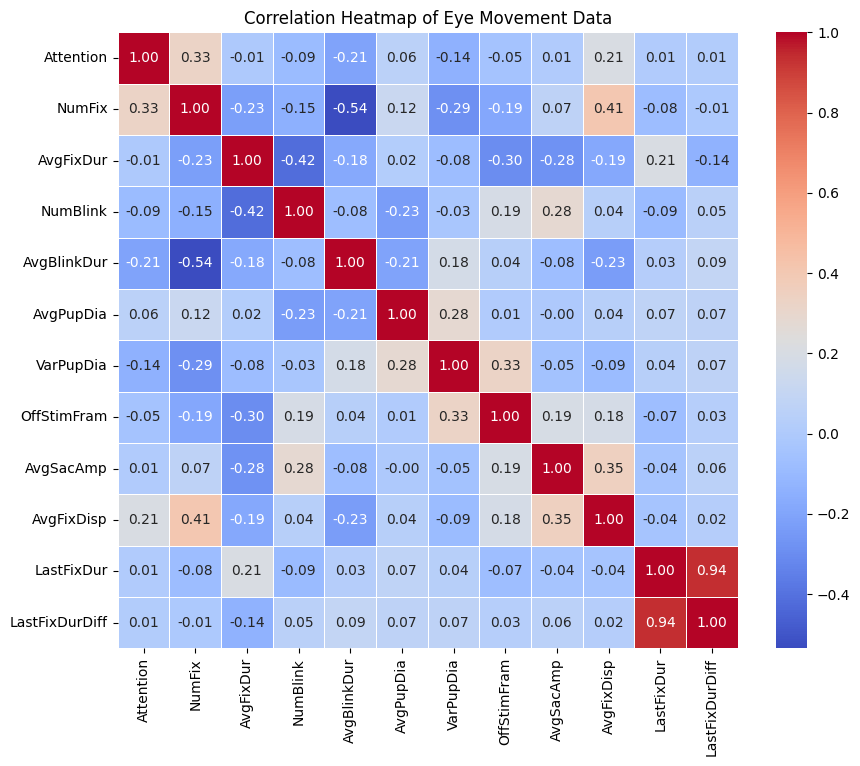

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv')
blacklist = ["22K", "25I", "29N", "39Y", "32S", "37T"]
df = df[~df['Participant'].isin(blacklist)]
X = df[['Attention', 'NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Eye Movement Data")
plt.show()

### 3.3 Between-group variation and Within-group variation
**Mixed-effects analysis**
- This approach allows us to examine both between-group (across different participants) and within-group (within the same participant) variations.

In [48]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the data
file_path = '../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_30sec.csv'
df = pd.read_csv(file_path)
blacklist = ["22K", "25I", "29N", "39Y", "32S", "37T"]
df = df[~df['Participant'].isin(blacklist)]

# Ensure 'Attention' is a categorical variable
df['Attention'] = df['Attention'].astype('category')

# Analyzing variation in NumFix
model_NumFix = smf.mixedlm("NumFix ~ 1", df, groups=df["Participant"], re_formula="~1")
result_NumFix = model_NumFix.fit()
print("\nMixed-Effects Model Results for NumFix:")
print(result_NumFix.summary())

# Analyzing variation in AvgFixDisp
model_AvgFixDisp = smf.mixedlm("AvgFixDisp ~ 1", df, groups=df["Participant"], re_formula="~1")
result_AvgFixDisp = model_AvgFixDisp.fit()
print("\nMixed-Effects Model Results for AvgFixDisp:")
print(result_AvgFixDisp.summary())



Mixed-Effects Model Results for NumFix:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: NumFix    
No. Observations: 816     Method:             REML      
No. Groups:       34      Scale:              122.5827  
Min. group size:  24      Log-Likelihood:     -3166.2433
Max. group size:  24      Converged:          Yes       
Mean group size:  24.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     63.337    1.604 39.480 0.000 60.193 66.481
Group Var     82.397    1.986                           


Mixed-Effects Model Results for AvgFixDisp:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: AvgFixDisp
No. Observations: 816     Method:             REML      
No. Groups:       34      Scale:              0.0014    
Min. group size:  24 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


**Comparing Variance Components**
- NumFix Variance Comparison:
    - Between-Group Variance: 82.397
    - Within-Group Variance: 122.5827
    - The within-group variance is greater than the between-group variance, indicating that there is more variability in the number of fixations within each participant across different stimuli than there is between different participants.

- AvgFixDisp Variance Comparison:
    - Between-Group Variance: 0.001
    - Within-Group Variance: 0.0014
    - Similar to NumFix, the within-group variance slightly exceeds the between-group variance, suggesting that the variability in average fixation displacement within participants across different stimuli is slightly larger than the variability between different participants.


**Interpretation and Conclusions**

These results suggest that for both the number of fixations (NumFix) and the average fixation displacement (AvgFixDisp), within-group variation (variation within each participant across different stimuli) is greater than between-group variation (variation among different participants). This could imply that individual participants' responses to stimuli are more variable within themselves than they are compared to other participants. 